# Imports

In [1]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler, AutoencoderKL, UniPCMultistepScheduler
import torch
from utils import get_device, plot_img

/home/shane/projects/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


# Constants

In [2]:
model_id = "stabilityai/stable-diffusion-2-1"
inf_steps = 20
device = get_device()
prompt = "portrait photo of a old warrior chief, tribal panther make up, blue on red, serious eyes, in front of forest 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta"

# Create Model

In [3]:
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
# Scheduler type - Euler has better quality, DPM is faster
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
#pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
pipe.enable_attention_slicing()
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to("cuda")
pipe.vae = vae

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 212163.24it/s]
/home/shane/projects/.venv/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


# Baseline

100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


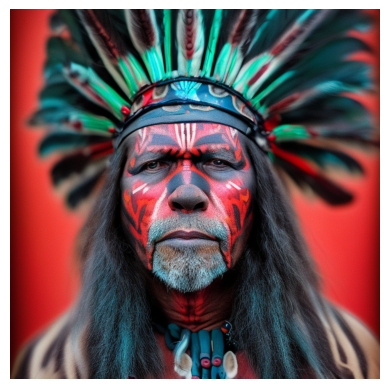

In [4]:
generator = torch.Generator("cuda").manual_seed(60)   
image = pipe(prompt, generator=generator, num_inference_steps=inf_steps).images[0]
plot_img(image)

# cuDNN auto-tuner

100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


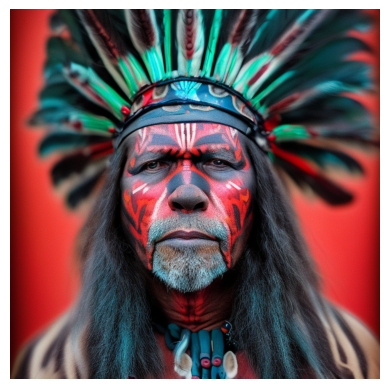

In [5]:
torch.backends.cudnn.benchmark = True
generator = torch.Generator("cuda").manual_seed(60)   
image = pipe(prompt, generator=generator, num_inference_steps=inf_steps).images[0]
plot_img(image)

# Sliced Attention

100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


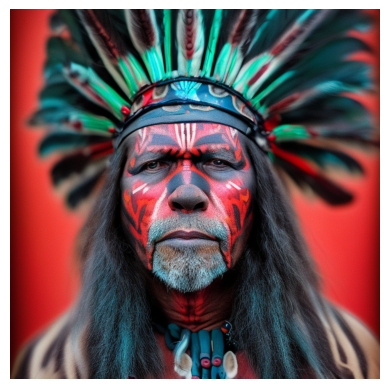

In [6]:
# Doesn't work with xformers - xformers takes precedence if both enabled
pipe.enable_attention_slicing()
generator = torch.Generator("cuda").manual_seed(60)   
image = pipe(prompt, generator=generator, num_inference_steps=inf_steps).images[0]
plot_img(image)

# VAE slicing

100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


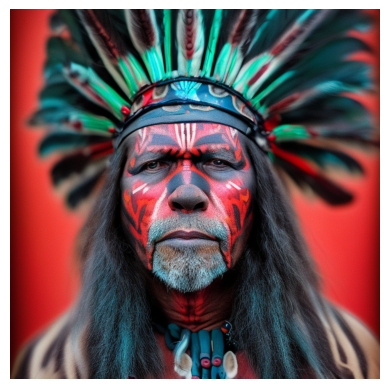

In [7]:
pipe.enable_vae_slicing()
generator = torch.Generator("cuda").manual_seed(60)   
image = pipe(prompt, generator=generator, num_inference_steps=inf_steps).images[0]
plot_img(image)

# Large images

100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


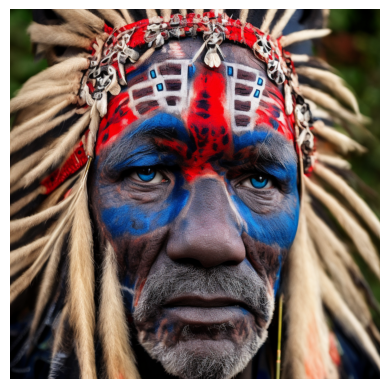

In [5]:
# This only just fits on 8GB GPU - so had to apply all the memory saving tricks
torch.backends.cudnn.benchmark = True
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_vae_slicing()
generator = torch.Generator("cuda").manual_seed(60)   
image = pipe(prompt, width=1024, height=1024, generator=generator, num_inference_steps=inf_steps).images[0]
plot_img(image)

# VAE tiling for large images (4k)

100%|██████████| 20/20 [04:36<00:00, 13.83s/it]


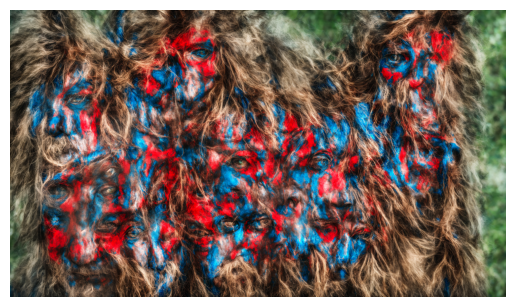

In [4]:
# Can't move model to cuda here - needs to be left on default due to sequential CPU offload
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_vae_tiling()
pipe.enable_xformers_memory_efficient_attention()
#pipe.enable_model_cpu_offload()
# Required to run on 8GB GPU
pipe.enable_sequential_cpu_offload()
generator = torch.Generator("cuda").manual_seed(60)   
image = pipe(prompt, width=3840, height=2224, num_inference_steps=20).images[0]
plot_img(image)